# Librerias

In [1]:
import os
import numpy as np
import pandas as pd
import string
import re
from matplotlib import pyplot as plt
import cv2
from skimage.feature import hog
from skimage import exposure, io
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add, Flatten, TimeDistributed, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Datos

In [11]:
#caps = "Input/captions.txt"
caps = '/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/Input/captions.txt'

def cargar_descripciones(file):
    mapping = {}
    with open(file, 'r') as f:
        for line in f:
            tokens = line.split(',')
            image_id, image_desc = tokens[0], tokens[1:]
            image_id = image_id.split('.')[0]
            image_desc = ' '.join(image_desc)
            if image_id not in mapping:
                mapping[image_id] = []
            mapping[image_id].append(image_desc)
    return mapping

def limpiar_desc(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

# Cargar las descripciones de las imágenes
descriptores = cargar_descripciones(caps)
del descriptores['image']
print('Frases %d cargadas' % len(descriptores))

# Limpiar las descripciones
limpiar_desc(descriptores)

# Ver algunas de las descripciones
for key in list(descriptores.keys())[:5]:
    print(key, descriptores[key])


Frases 8091 cargadas
1000268201_693b08cb0e ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']
1001773457_577c3a7d70 ['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other']
1002674143_1b742ab4b8 ['little girl covered in paint sits in front of painted rainbow with her hands in bowl', 'little girl is sitting in front of large painted rainbow', 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it', 'there is girl with pigtails sitting in front of rainbow painting', 'young girl with pigtails painting o

In [12]:
from PIL import Image

# Ruta del directorio que contiene las imágenes
#photos_dir = "./Input/Images"
photos_dir = '/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/Input/Images'

# Función para cargar imágenes
def cargar_imag(file_paths):
    photos = {}
    for file_path in file_paths:
        photo_id = os.path.basename(file_path).split(".")[0]
        image = Image.open(file_path).convert('RGB')
        image = image.resize((224, 224))  # Redimensiona la imagen si es necesario
        image = np.array(image)
        image = image / 255.0
        photos[photo_id] = image
    return photos

# Rutas archivos
image_files = [os.path.join(photos_dir, file) for file in os.listdir(photos_dir)]

# Carga las imágenes
photos = cargar_imag(image_files[:2000])  # Carga solo las primeras 1000 imágenes

print("Número de imágenes cargadas:", len(photos))


Número de imágenes cargadas: 2000


In [13]:
#Toma los primeros 1000 descriptores correspondientes a las imagenes que cargamos
fotoskeys = list(photos.keys())
descript = {key: descriptores[key] for key in fotoskeys if key in descriptores}
len(descript)

2000

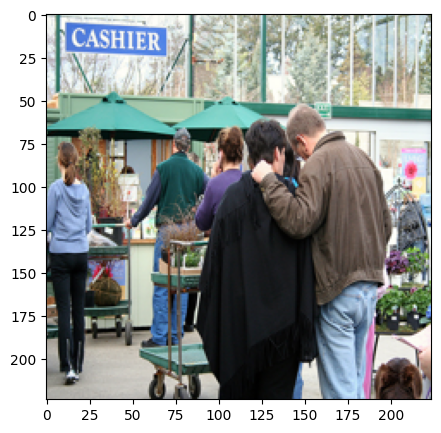

In [6]:
#Imagen reescalada
plt.figure(figsize=[5,5])
plt.imshow(photos['394161692_2576920777'], cmap='gray')

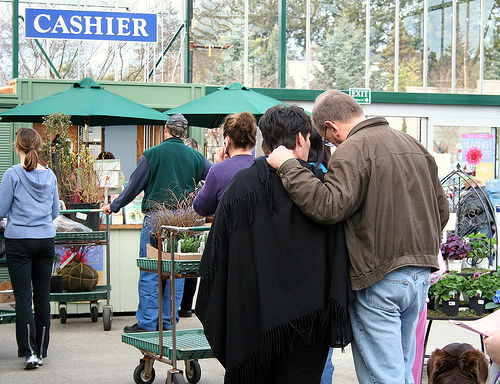

In [7]:
#Imagen sin reescalar
PIL.Image.open(str(image_files[0]))

# Exploración de datos

In [ ]:
# Mostrar algunas descripciones
for key, desc_list in list(descriptores.items())[:5]:
    print(f"Image ID: {key}")
    for desc in desc_list:
        print(f"Description: {desc}")
    print()

Image ID: 1000268201_693b08cb0e
Description: child in pink dress is climbing up set of stairs in an entry way
Description: girl going into wooden building
Description: little girl climbing into wooden playhouse
Description: little girl climbing the stairs to her playhouse
Description: little girl in pink dress going into wooden cabin

Image ID: 1001773457_577c3a7d70
Description: black dog and spotted dog are fighting
Description: black dog and tricolored dog playing with each other on the road
Description: black dog and white dog with brown spots are staring at each other in the street
Description: two dogs of different breeds looking at each other on the road
Description: two dogs on pavement moving toward each other

Image ID: 1002674143_1b742ab4b8
Description: little girl covered in paint sits in front of painted rainbow with her hands in bowl
Description: little girl is sitting in front of large painted rainbow
Description: small girl in the grass plays with fingerpaints in front o

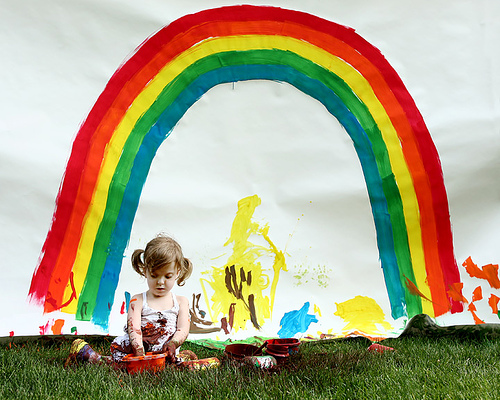

In [ ]:
#Imagen
path = '/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/Input/Images/'
imagen = '1002674143_1b742ab4b8.jpg'
PIL.Image.open(str(path+imagen))

# Guardar modelo

In [ ]:
# Guardar la arquitectura del modelo en formato JSON
def guardar_modelo(model,nombre):
    modelo = model.to_json()
    ruta = "/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/"+nombre+".json"
    with open(ruta, "w") as archivo:
        archivo.write(modelo)
    # Guardar los pesos del modelo en formato HDF5
    model.save_weights("/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/"+nombre+"_pesos.weights.h5")
    print("Modelo y pesos guardados en:", ruta)

In [ ]:
def guardar_modelo2(model,nombre):
    # Guardar el modelo completo
    ruta = "/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/"+nombre+".h5"
    model.save(ruta)
    print("Modelo guardado en:", ruta)

# Tokenizar

In [17]:
tokenizer = Tokenizer()

# Ajusta el tokenizer con todas las descripciones
all_descriptions = []
for desc_list in descriptores.values():
    all_descriptions.extend(desc_list)
tokenizer.fit_on_texts(all_descriptions)


In [18]:
# Define parametros de longitudes
def max_length2(descriptions):
    return max(len(desc.split()) for desc_list in descriptions.values() for desc in desc_list)

vocab_size = len(tokenizer.word_index) + 1
max_length = max_length2(descript)

# Crear secuencias

## Opcion 1

In [ ]:
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                if in_seq:
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=len(tokenizer.word_index) + 1)[0]
                    X1.append(photos[key])
                    X2.append(in_seq)
                    y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Crear secuencias
X1, X2, y = create_sequences(tokenizer, max_length, descript, photos)
#X1train, X2train, ytrain = create_sequences(tokenizer, max_length, descript, photos)
# Dividir en conjuntos de entrenamiento y validación
X1train, X1val, X2train, X2val, ytrain, yval = train_test_split(X1, X2, y, test_size=0.2, random_state=42)
# X1train = np.array(X1train)
# X2train = np.array(X2train,dtype='float64')
# ytrain = np.array(ytrain,dtype='float64')

In [ ]:
len(X1train), len(X2train), len(ytrain)

## Opcion 2

In [ ]:
# # Dividir los datos en conjuntos de entrenamiento y validación
# def train_val_split(descriptions, photos, test_size=0.2):
#     keys = list(descriptions.keys())
#     train_keys, val_keys = train_test_split(keys, test_size=test_size, random_state=42)

#     train_descriptions = {k: descriptions[k] for k in train_keys}
#     val_descriptions = {k: descriptions[k] for k in val_keys}

#     train_photos = {k: photos[k] for k in train_keys}
#     val_photos = {k: photos[k] for k in val_keys}

#     return train_descriptions, val_descriptions, train_photos, val_photos

# # Aplicar la división
# train_descriptions, val_descriptions, train_photos, val_photos = train_val_split(descript, photos)


In [ ]:
# # Función para crear secuencias de entrada y salida para el modelo
# def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
#     X1, X2, y = [], [], []
#     for key, desc_list in descriptions.items():
#         for desc in desc_list:
#             seq = tokenizer.texts_to_sequences([desc])[0]
#             for i in range(1, len(seq)):
#                 in_seq, out_seq = seq[:i], seq[i]
#                 if in_seq:
#                     in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#                     out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#                     X1.append(photos[key])
#                     X2.append(in_seq)
#                     y.append(out_seq)
#     return np.array(X1), np.array(X2), np.array(y)

# # Crear secuencias de entrenamiento
# X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_photos, vocab_size)

# # Crear secuencias de validación
# X1val, X2val, yval = create_sequences(tokenizer, max_length, val_descriptions, val_photos, vocab_size)


## Generador de datos

In [10]:
# Función para crear el generador de datos
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size):
    while True:
        keys = list(descriptions.keys())
        np.random.shuffle(keys)
        for i in range(0, len(keys), batch_size):
            X1, X2, y = [], [], []
            for j in range(i, min(len(keys), i + batch_size)):
                image_id = keys[j]
                photo = photos[image_id]
                desc_list = descriptions[image_id]
                for desc in desc_list:
                    seq = tokenizer.texts_to_sequences([desc])[0]
                    for k in range(1, len(seq)):
                        in_seq, out_seq = seq[:k], seq[k]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)
            yield [np.array(X1), np.array(X2)], np.array(y)

# Parámetros del generador
batch_size = 8

# Crear el generador de datos
train_generator = data_generator(descript, photos, tokenizer, max_length, vocab_size, batch_size)

# # Definir el modelo
# model = define_model_VGG16(vocab_size, max_length)

# # Entrenar el modelo usando el generador de datos
# steps_per_epoch = len(descript) // batch_size
# model.fit(train_generator, epochs=20, steps_per_epoch=steps_per_epoch, verbose=2)


# Modelo

## Modelo VGG16

In [12]:
#Define modelo con VGG16 y LSTM
def define_model_VGG16(vocab_size, max_length):
    # Encoder
    cnn_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    for layer in cnn_model.layers:
      layer.trainable = False
    #cnn_model.trainable = False
    flat1 = Flatten()(cnn_model.layers[-1].output)
    dense1 = Dense(256, activation='relu')(flat1)

    # LSTM para decoder
    inputs2 = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    lstm1 = LSTM(256)(embedding)

    # Combinación VGG16 y LSTM
    decoder1 = Add()([dense1, lstm1])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Modelo
    model = Model(inputs=[cnn_model.input, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

# Define el modelo
modelVGG16 = define_model_VGG16(vocab_size, max_length)

# Muestra la arquitectura del modelo
modelVGG16.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [11]:
# Configurar early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
historyVGG16 = modelVGG16.fit([X1train, X2train], ytrain, epochs=20, batch_size=32, verbose=1, validation_data=([X1val, X2val], yval), callbacks=[early_stopping])

Epoch 1/20
203/203 [==============================] - 76s 313ms/step - loss: 6.5172 - val_loss: 5.9098
Epoch 2/20
203/203 [==============================] - 43s 211ms/step - loss: 5.4171 - val_loss: 5.7834
Epoch 3/20
203/203 [==============================] - 43s 212ms/step - loss: 5.0113 - val_loss: 5.6339
Epoch 4/20
203/203 [==============================] - 43s 211ms/step - loss: 4.6678 - val_loss: 5.6126
Epoch 5/20
203/203 [==============================] - 42s 209ms/step - loss: 4.3655 - val_loss: 5.6203
Epoch 6/20
203/203 [==============================] - 42s 207ms/step - loss: 4.1043 - val_loss: 5.6217
Epoch 7/20
203/203 [==============================] - 43s 213ms/step - loss: 3.8621 - val_loss: 5.6596


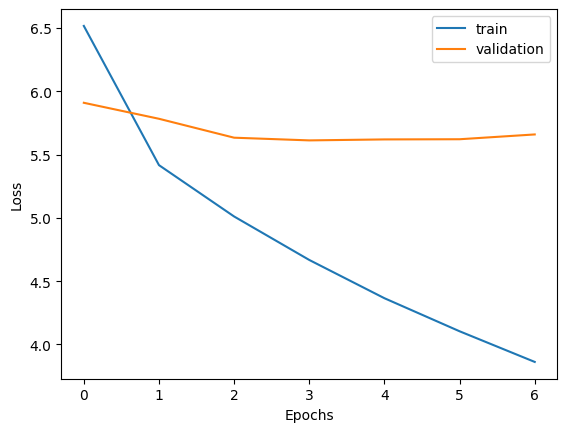

In [12]:
# Gráfico de pérdida
plt.plot(historyVGG16.history['loss'], label='train')
plt.plot(historyVGG16.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
guardar_modelo2(modelVGG16,'VGG16')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo guardado en: /content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/VGG16.h5


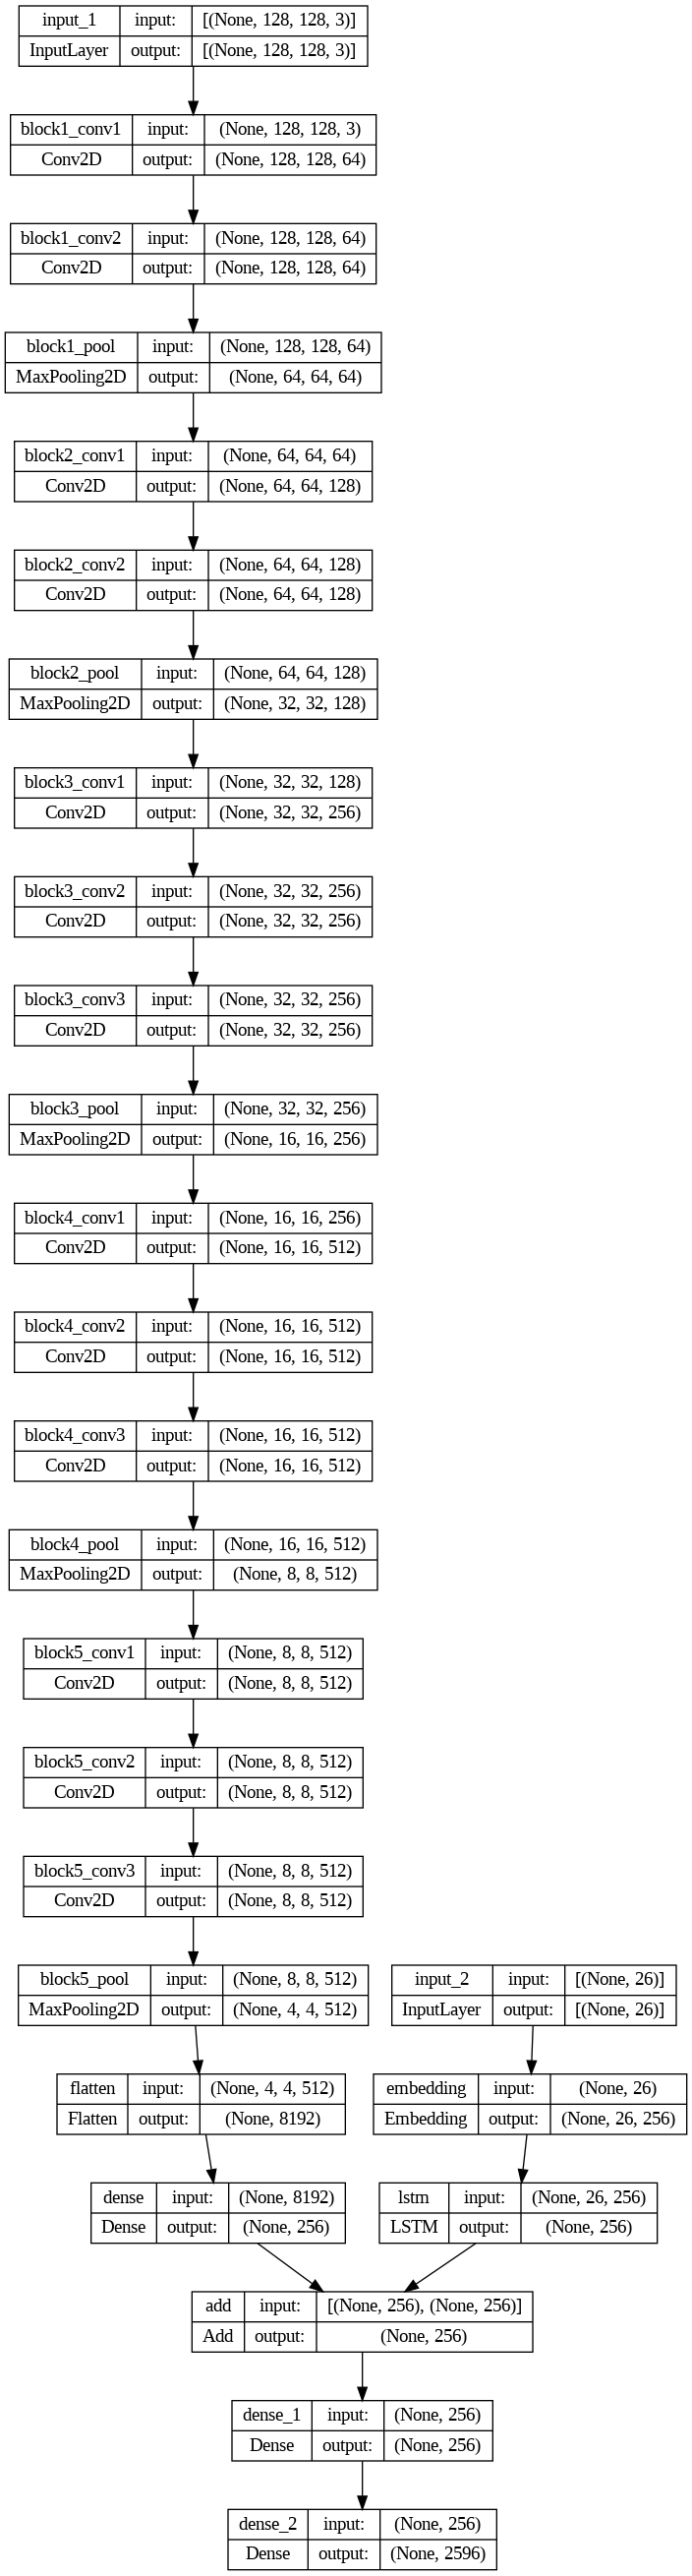

In [ ]:
# Visualizar la arquitectura del modelo
from tensorflow.keras.utils import plot_model
plot_model(modelVGG16, to_file='model.png', show_shapes=True, show_layer_names=True)

## Modelo ResNet50

In [ ]:
# Definir el modelo
def define_model_ResNet50(vocab_size, max_length):
    # Modelo de extracción de características
    inputs1 = Input(shape=(128, 128, 3))
    base_model = ResNet50(include_top=False, pooling='avg')(inputs1)
    fe1 = Dropout(0.5)(base_model)
    fe2 = Dense(256, activation='relu')(fe1)

    # Modelo de procesamiento de secuencias
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Decodificador (Decoder)
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Modelo final
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Crear y compilar el modelo
modelResNet50 = define_model_ResNet50(vocab_size, max_length)
modelResNet50.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_23 (InputLayer)       [(None, 24)]                 0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 2048)                 2358771   ['input_21[0][0]']            
                                                          2                                       
                                                                                                  
 embedding_10 (Embedding) 

In [ ]:
# Configurar early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
#X1train_gpu = tf.constant(X1train)
#X2train_gpu = tf.constant(X2train)
with tf.device('/device:GPU:0'):
    X1train_gpu = tf.constant(X1train)
    X2train_gpu = tf.constant(X2train)

historyResNet50 = modelResNet50.fit([X1train_gpu, X2train_gpu], ytrain, epochs=20, batch_size=24, verbose=1, validation_data=([X1val, X2val], yval), callbacks=[early_stopping])
#historyResNet50 = modelResNet50.fit([X1train_gpu, X2train_gpu], ytrain, epochs=20, batch_size=64, verbose=2, validation_data=([X1val, X2val], yval), callbacks=[early_stopping])
#historyResNet50 = modelResNet50.fit([X1train, X2train], ytrain, epochs=20, batch_size=64, verbose=2, validation_data=([X1val, X2val], yval), callbacks=[early_stopping])

Epoch 1/20
412/412 [==============================] - 96s 140ms/step - loss: 5.8799 - val_loss: 5.7125
Epoch 2/20
412/412 [==============================] - 48s 117ms/step - loss: 5.1677 - val_loss: 5.6041
Epoch 3/20
412/412 [==============================] - 49s 118ms/step - loss: 4.6032 - val_loss: 5.3846
Epoch 4/20
412/412 [==============================] - 48s 117ms/step - loss: 4.1554 - val_loss: 5.3024
Epoch 5/20
412/412 [==============================] - 48s 117ms/step - loss: 3.7915 - val_loss: 5.4599
Epoch 6/20
412/412 [==============================] - 48s 117ms/step - loss: 3.4757 - val_loss: 5.5949
Epoch 7/20
412/412 [==============================] - 48s 117ms/step - loss: 3.1617 - val_loss: 6.0224


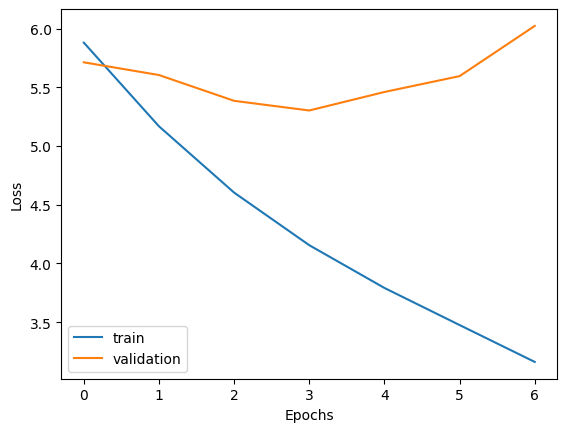

In [ ]:
# Gráfico de pérdida
plt.plot(historyResNet50.history['loss'], label='train')
plt.plot(historyResNet50.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
guardar_modelo(modelResNet50,'ResNet50')

Modelo y pesos guardados en: /content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/ResNet50.json


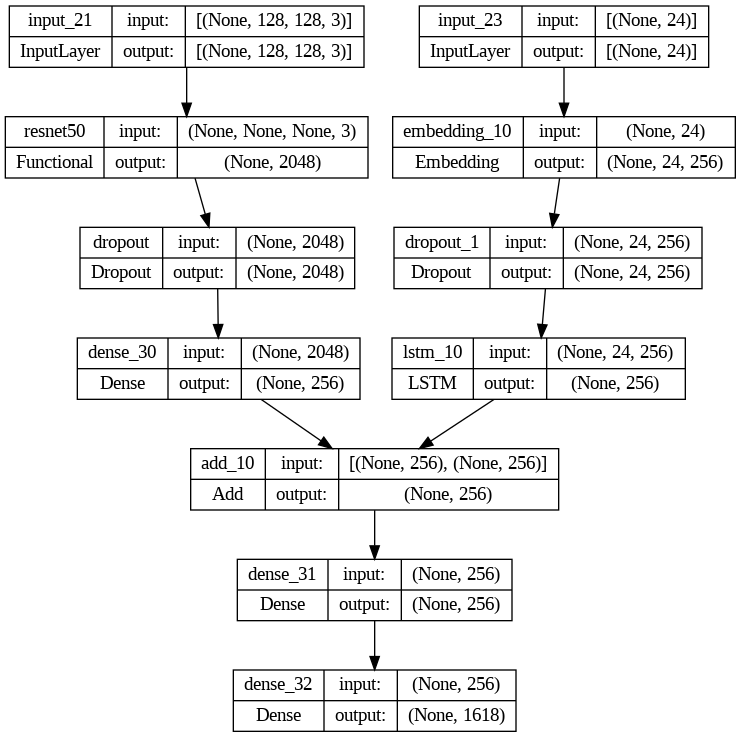

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(modelResNet50, to_file='model.png', show_shapes=True, show_layer_names=True)

# Modelos separados

## VGG16 V2

In [7]:
vgg16_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
last = vgg16_model.layers[-2].output # Output of the penultimate layer of ResNet model
vgg16 = Model(inputs=vgg16_model.input,outputs=last)
vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Función para cargar imágenes
def predecir_imag(file_paths,model):
    featureP = {}
    for file_path in file_paths:
        photo_id = os.path.basename(file_path).split(".")[0]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224))
        image = image.reshape(1,224,224,3)
        features = model.predict(image).reshape(4096,) # Feature extraction from images
        featureP[photo_id] = features
    return featureP

# Rutas archivos
image_files = [os.path.join(photos_dir, file) for file in os.listdir(photos_dir)]

# Carga las imágenes
imagenes_vgg16 = predecir_imag(image_files[:2000],vgg16)
print("Número de imágenes cargadas:", len(imagenes_vgg16))

1/1 [==============================] - 0s 21ms/step
Número de imágenes cargadas: 2000


In [19]:
def define_lstm(vocab_size,MAX_LEN,input_shape):
  embedding_len = 128
  MAX_LEN = max_length

  # Model for image feature extraction
  img_model = Sequential()
  img_model.add(Dense(embedding_len,input_shape=input_shape,activation='relu'))
  img_model.add(RepeatVector(MAX_LEN,input_shape=(None, None, None, 128)))

  # Model for generating captions from image features
  captions_model = Sequential()
  captions_model.add(Embedding(input_dim=vocab_size,output_dim=embedding_len,input_length=MAX_LEN))
  captions_model.add(LSTM(256,return_sequences=True))
  captions_model.add(TimeDistributed(Dense(embedding_len)))

  # Concatenating the outputs of image and caption models
  concat_output = Concatenate()([img_model.output,captions_model.output])
  # First LSTM Layer
  output = LSTM(units=128,return_sequences=True)(concat_output)
  # Second LSTM Layer
  output = LSTM(units=512,return_sequences=False)(output)
  # Output Layer
  output = Dense(units=vocab_size,activation='softmax')(output)
  # Creating the final model
  final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
  final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy',run_eagerly=True)

  return final_model

input_shape=(4096,)
# Define el modelo
lstm_dense = define_lstm(vocab_size, max_length,input_shape)

# Muestra la arquitectura del modelo
lstm_dense.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 26)]                 0         []                            
 r)                                                                                               
                                                                                                  
 dense_input (InputLayer)    [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 26, 128)              1121792   ['embedding_input[0][0]']     
                                                                                                  
 dense (Dense)               (None, 128)                  524416    ['dense_input[0][0]']   

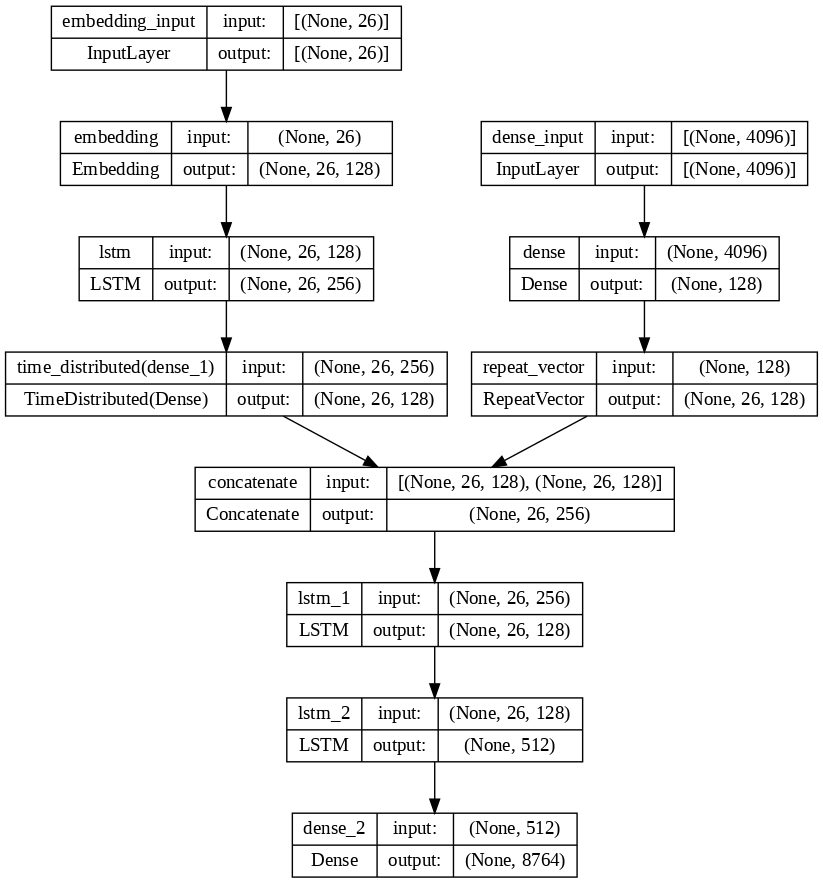

In [20]:
plot_model(lstm_dense,'model.png',show_shapes=True,dpi=100)

In [21]:
def create_sequences(tokenizer, max_length, descriptions, pho):
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                if in_seq:
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=len(tokenizer.word_index) + 1)[0]
                    X1.append(pho[key])
                    X2.append(in_seq)
                    y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Crear secuencias
#X1, X2, y = create_sequences(tokenizer, max_length, descript, photos)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, descript, imagenes_vgg16)
# Dividir en conjuntos de entrenamiento y validación
#X1train, X1val, X2train, X2val, ytrain, yval = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [22]:
print(f"X1train shape: {X1train.shape}")
print(f"X2train shape: {X2train.shape}")
print(f"ytrain shape: {ytrain.shape}")

X1train shape: (82510, 4096)
X2train shape: (82510, 26)
ytrain shape: (82510, 8764)


In [23]:
# Check for missing values
print(f"Number of missing values in X1train: {np.count_nonzero(np.isnan(X1train))}")
print(f"Number of missing values in X2train: {np.count_nonzero(np.isnan(X2train))}")
print(f"Number of missing values in ytrain: {np.count_nonzero(np.isnan(ytrain))}")

# Check for incorrect values
print(f"Minimum value in X1train: {np.min(X1train)}")
print(f"Maximum value in X1train: {np.max(X1train)}")
print(f"Minimum value in X2train: {np.min(X2train)}")
print(f"Maximum value in X2train: {np.max(X2train)}")
print(f"Minimum value in ytrain: {np.min(ytrain)}")
print(f"Maximum value in ytrain: {np.max(ytrain)}")

Number of missing values in X1train: 0
Number of missing values in X2train: 0
Number of missing values in ytrain: 0
Minimum value in X1train: 0.0
Maximum value in X1train: 23.104623794555664
Minimum value in X2train: 0
Maximum value in X2train: 8762
Minimum value in ytrain: 0.0
Maximum value in ytrain: 1.0


In [32]:
# Convert X1train to a NumPy array if it is not already
if not isinstance(X1train, np.ndarray):
    X1train = np.array(X1train)

# Ensure that X1train is a float32 tensor
X1train = X1train.astype(np.float32)

In [ ]:
mc = ModelCheckpoint('VGG16_V2.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

lstm_dense.fit([X1train, X2train],
                ytrain,
                batch_size=12,
                callbacks=mc,
                epochs=10)

# steps_per_epoch = len(descript) // 512
# lstm_dense.fit(train_generator,
#                steps_per_epoch=steps_per_epoch,
#                 batch_size=64,
#                 callbacks=mc,
#                 epochs=10)

Epoch 1/10
6876/6876 [==============================] - ETA: 0s - loss: 6.5004 - accuracy: 0.0588
Epoch 1: accuracy improved from -inf to 0.05884, saving model to VGG16_V2.h5
6876/6876 [==============================] - 533s 77ms/step - loss: 6.5004 - accuracy: 0.0588
Epoch 2/10
6876/6876 [==============================] - ETA: 0s - loss: 6.4040 - accuracy: 0.0757
Epoch 2: accuracy improved from 0.05884 to 0.07569, saving model to VGG16_V2.h5
6876/6876 [==============================] - 540s 78ms/step - loss: 6.4040 - accuracy: 0.0757
Epoch 3/10
6876/6876 [==============================] - ETA: 0s - loss: 6.2651 - accuracy: 0.1039
Epoch 3: accuracy improved from 0.07569 to 0.10390, saving model to VGG16_V2.h5
6876/6876 [==============================] - 549s 80ms/step - loss: 6.2651 - accuracy: 0.1039
Epoch 4/10
6876/6876 [==============================] - ETA: 0s - loss: 6.1068 - accuracy: 0.1252
Epoch 4: accuracy improved from 0.10390 to 0.12525, saving model to VGG16_V2.h5
6876/6876

## ResNet50 V2

In [ ]:
inception_model = ResNet50(include_top=True)
last = inception_model.layers[-2].output # Output of the penultimate layer of ResNet model
model = Model(inputs=inception_model.input,outputs=last)
model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [ ]:

# Función para cargar imágenes
def predecir_imag(file_paths,model):
    featureP = {}
    for file_path in file_paths:
        photo_id = os.path.basename(file_path).split(".")[0]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224))
        image = image.reshape(1,224,224,3)
        features = model.predict(image).reshape(2048,) # Feature extraction from images
        featureP[photo_id] = features
    return featureP

# Rutas archivos
image_files = [os.path.join(photos_dir, file) for file in os.listdir(photos_dir)]

# Carga las imágenes
features = predecir_imag(image_files[:1000],model)
print("Número de imágenes cargadas:", len(features))

1/1 [==============================] - 0s 23ms/step
Número de imágenes cargadas: 1000


In [ ]:
def create_sequences(tokenizer, max_length, descriptions, pho):
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                if in_seq:
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=len(tokenizer.word_index) + 1)[0]
                    X1.append(pho[key])
                    X2.append(in_seq)
                    y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Crear secuencias
#X1, X2, y = create_sequences(tokenizer, max_length, descript, photos)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, descript, features)
# Dividir en conjuntos de entrenamiento y validación
#X1train, X1val, X2train, X2val, ytrain, yval = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [ ]:
len(X1train), len(X2train), len(ytrain)

(41443, 41443, 41443)

In [ ]:
X1train.shape, X2train.shape, ytrain.shape

((41443, 2048), (41443, 26), (41443, 8764))

In [ ]:
embedding_len = 128
MAX_LEN = max_length

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))

img_model.summary()

# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(LSTM(256,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))

captions_model.summary()

# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First LSTM Layer
output = LSTM(units=128,return_sequences=True)(concat_output)
# Second LSTM Layer
output = LSTM(units=512,return_sequences=False)(output)
# Output Layer
output = Dense(units=vocab_size,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
final_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               262272    
                                                                 
 repeat_vector_3 (RepeatVec  (None, 26, 128)           0         
 tor)                                                            
                                                                 
Total params: 262272 (1.00 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 26, 128)           1121792   
                                                                 
 lstm_9 (LSTM)               (None, 26, 256)           394240 

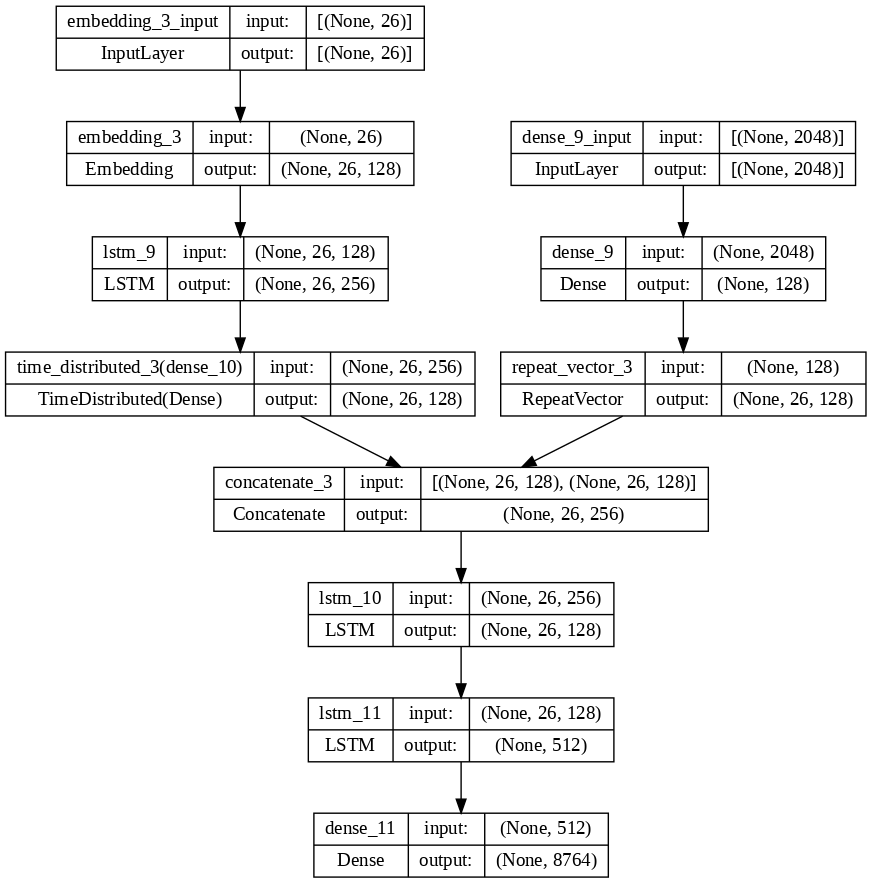

In [ ]:
plot_model(final_model,'model.png',show_shapes=True,dpi=100)

In [ ]:
mc = ModelCheckpoint('ResNet50V2.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)
final_model.fit([X1train, X2train],
                ytrain,
                batch_size=512,
                callbacks=mc,
                epochs=100)

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 3.6489 - accuracy: 0.0828
Epoch 1: accuracy improved from -inf to 0.08279, saving model to ResNet50V2.h5
81/81 [==============================] - 5s 66ms/step - loss: 3.6489 - accuracy: 0.0828
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 3.6403 - accuracy: 0.0800
Epoch 2: accuracy did not improve from 0.08279
81/81 [==============================] - 5s 64ms/step - loss: 3.6403 - accuracy: 0.0800
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 3.6335 - accuracy: 0.0822
Epoch 3: accuracy did not improve from 0.08279
81/81 [==============================] - 5s 65ms/step - loss: 3.6335 - accuracy: 0.0822
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 3.6282 - accuracy: 0.0817
Epoch 4: accuracy did not improve from 0.08279
81/81 [==============================] - 5s 66ms/step - loss: 3.6282 - accuracy: 0.0817
Epoch 5/100
81/81 [=============================

In [ ]:
new_image_path = '/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/Input/Images/12830823_87d2654e31.jpg'

# Función para mapear un entero a una palabra
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Función para generar una descripción para una imagen
def generate_desc(model, tokenizer, photo, max_length):
    in_text = ''
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text
photos2 = cargar_imag(image_files[6000:6010])
fe2 = predecir_imag(image_files[6000:6010],model)
i=1
for key, photo in fe2.items():
    phot = np.expand_dims(photo, axis=0)
    description = generate_desc(final_model, tokenizer, phot, max_length)
    print("\nDescripción "+str(i)+" generada:", description)
    # for d in descriptores[key]:
    #     print("Descripciones reales: " + d)
    plt.figure(figsize=[5,5])
    #plt.title("Descripción generada:" + description)
    plt.title("Descripción" + str(i))
    plt.imshow(photos2[key], cmap='gray')
    i+=1

Output hidden; open in https://colab.research.google.com to view.

# Calibración

## VGG16

In [ ]:
# Hiperparámetros a ajustar
epochs = [10, 20]
batch_sizes = [24, 32]
lstm_units = [256, 512]

best_val_loss = float('inf')
best_params = None

for epoch in epochs:
    for batch_size in batch_sizes:
        for units in lstm_units:
            print(f'Entrenando modelo con epochs={epoch}, batch_size={batch_size}, lstm_units={units}')

            model = define_model_VGG16(vocab_size, max_length)
            model.compile(optimizer='adam', loss='categorical_crossentropy')
            # Configurar early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

            history = model.fit(
                [X1train, X2train], ytrain,
                epochs=epoch,
                batch_size=batch_size,
                verbose=1,
                validation_data=([X1val, X2val], yval),
                callbacks=[early_stopping]
            )

            val_loss = min(history.history['val_loss'])

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = (epoch, batch_size, units)

print(f'Mejores parametros: epochs={best_params[0]}, batch_size={best_params[1]}, lstm_units={best_params[2]}')

Entrenando modelo con epochs=10, batch_size=24, lstm_units=256
Epoch 1/10
412/412 [==============================] - 46s 92ms/step - loss: 5.7125 - val_loss: 5.5671
Epoch 2/10
412/412 [==============================] - 29s 71ms/step - loss: 4.6873 - val_loss: 5.4082
Epoch 3/10
412/412 [==============================] - 29s 71ms/step - loss: 3.9203 - val_loss: 5.3292
Epoch 4/10
412/412 [==============================] - 29s 70ms/step - loss: 3.2693 - val_loss: 5.5063
Epoch 5/10
412/412 [==============================] - 29s 71ms/step - loss: 2.7155 - val_loss: 5.8162
Epoch 6/10
412/412 [==============================] - 29s 70ms/step - loss: 2.2471 - val_loss: 6.0424
Entrenando modelo con epochs=10, batch_size=24, lstm_units=512
Epoch 1/10
412/412 [==============================] - 41s 89ms/step - loss: 5.6868 - val_loss: 5.5587
Epoch 2/10
412/412 [==============================] - 29s 72ms/step - loss: 4.6382 - val_loss: 5.3507
Epoch 3/10
412/412 [==============================] - 29s 

## ResNet50

In [ ]:
# Hiperparámetros a ajustar
epochs = [20]
batch_sizes = [16, 32]
lstm_units = [256, 512]

best_val_loss = float('inf')
best_params = None

for epoch in epochs:
    for batch_size in batch_sizes:
        for units in lstm_units:
            print(f'Entrenando modelo con epochs={epoch}, batch_size={batch_size}, lstm_units={units}')

            model = define_model_ResNet50(vocab_size, max_length)
            model.compile(optimizer='adam', loss='categorical_crossentropy')

            history = model.fit(
                [X1train, X2train], ytrain,
                epochs=epoch,
                batch_size=batch_size,
                verbose=1,
                validation_data=([X1val, X2val], yval),
                callbacks=[early_stopping]
            )

            val_loss = min(history.history['val_loss'])

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = (epoch, batch_size, units)

print(f'Mejores parametros: epochs={best_params[0]}, batch_size={best_params[1]}, lstm_units={best_params[2]}')

Entrenando modelo con epochs=20, batch_size=16, lstm_units=256
Epoch 1/20
618/618 [==============================] - 102s 108ms/step - loss: 5.9051 - val_loss: 5.6886
Epoch 2/20
618/618 [==============================] - 58s 94ms/step - loss: 5.0141 - val_loss: 5.3264
Epoch 3/20
618/618 [==============================] - 58s 93ms/step - loss: 4.3641 - val_loss: 5.2678
Epoch 4/20
618/618 [==============================] - 58s 94ms/step - loss: 3.9221 - val_loss: 5.3206
Epoch 5/20
618/618 [==============================] - 58s 93ms/step - loss: 3.5628 - val_loss: 5.5965
Epoch 6/20
618/618 [==============================] - 58s 93ms/step - loss: 3.2294 - val_loss: 5.7556
Entrenando modelo con epochs=20, batch_size=16, lstm_units=512
Epoch 1/20
618/618 [==============================] - 98s 109ms/step - loss: 5.8513 - val_loss: 5.6989
Epoch 2/20
618/618 [==============================] - 61s 99ms/step - loss: 5.0450 - val_loss: 5.4131
Epoch 3/20
618/618 [==============================] - 6

# Predicción

In [ ]:
imagen = '/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/Input/Images/102351840_323e3de834.jpg'


In [ ]:
# Función para cargar y preprocesar una nueva imagen
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image)
    image = image / 255.0  # Normalizar los píxeles a valores entre 0 y 1
    image = np.expand_dims(image, axis=0)  # Añadir una dimensión extra para el batch
    return image

# Función para mapear un entero a una palabra
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Función para generar una descripción para una imagen
def generate_desc(model, tokenizer, photo, max_length):
    in_text = ''
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Cargar el modelo entrenado
#model_path = 'model.h5'
#model = load_model(model_path)

# Ruta a la nueva imagen
#new_image_path = '/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/Input/Images/104136873_5b5d41be75.jpg'

new_image_path = '/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/Input/Images/12830823_87d2654e31.jpg'

# Cargar y preprocesar la imagen
new_image = load_and_preprocess_image(new_image_path)

# Generar la descripción para la nueva imagen
description = generate_desc(modelVGG16, tokenizer, new_image, max_length)
print("Descripción generada:", description)


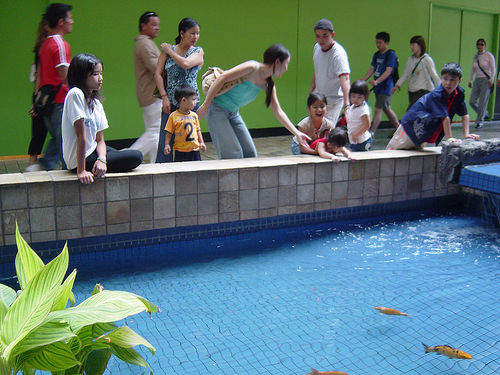

In [ ]:
#Imagen
PIL.Image.open(str(new_image_path))

# Cargar modelo y predicciones

In [ ]:
# Para cargar el modelo en otro script o sesión
from tensorflow.keras.models import load_model
ruta = "/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/VGG16.h5"
# Cargar el modelo guardado
modelo_VGG16 = load_model(ruta)

In [ ]:
new_image_path = '/content/drive/MyDrive/Cursos/Maestria MIAD/4.2_Deep Learning/Proyecto final/Input/Images/12830823_87d2654e31.jpg'
photos2 = cargar_imag(image_files[6000:6010])
i=1
for key, photo in photos2.items():
    phot = np.expand_dims(photo, axis=0)
    description = generate_desc(modelo_VGG16, tokenizer, phot, max_length)
    print("\nDescripción "+str(i)+" generada:", description)
    # for d in descriptores[key]:
    #     print("Descripciones reales: " + d)
    plt.figure(figsize=[5,5])
    #plt.title("Descripción generada:" + description)
    plt.title("Descripción" + str(i))
    plt.imshow(photos2[key], cmap='gray')
    i+=1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
descriptores[key]

['long bicyclist wearing white helmet riding down mountain path',
 'man riding bike down hill',
 'person on bike coming down off wooded hill',
 'woman is riding bicycle through forest',
 'person riding bicycle down dirt hill in wooded area']